In [2]:
import jieba
import pandas as pd
import numpy as np
import gensim.models.word2vec as w2v

In [3]:
def train_w2v(file_name,sg=1, size=50, window=3, min_count=1):
    # w2v model train
    with open(file_name,'r') as rfile, open('w2v_input.txt','w') as wfile:
        for iline in rfile.readlines():
            newline=' '.join(jieba.lcut(iline))
            wfile.write(newline)
    sentences = w2v.LineSentence('w2v_input.txt')  
    model = w2v.Word2Vec(sentences, sg=sg, size=size, window=window, min_count=min_count)   
    model.save('w2v_input.model')
    return 'w2v_input.model'

In [9]:
def get_sen_vec(word_str):
    cut_word=jieba.lcut(word_str)
    vec=[]
    for icut in cut_word:
        try:
            icut=str(icut)
            vec_value=w2v_model.wv[icut]
            vec.append(vec_value)
        except KeyError:
            continue
    sen_vec=list(np.array(vec).mean(axis=0))
    return sen_vec

In [5]:
model_name=train_w2v('pos_neg.txt',sg=1, size=128, window=5, min_count=3)

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/_t/wschnxms2rlgr_txwwx6p1g40000gn/T/jieba.cache
Loading model cost 1.177 seconds.
Prefix dict has been built succesfully.


In [6]:
w2v_model=w2v.Word2Vec.load(model_name)

In [7]:
neg_df=pd.read_table('neg.txt',sep='\t',names=['label','chat'])

pos_df=pd.read_table('pos.txt',sep='\t',names=['label','chat'])

In [8]:
neg_df.head()

,label,chat
0,-1,标准间太差房间还不如3星的而且设施非常陈旧.建议酒店把老的标准间从新改善.
1,-1,服务态度极其差，前台接待好象没有受过培训，连基本的礼貌都不懂，竟然同时接待几个客人；大堂副理...
2,-1,地理位置还不错，到哪里都比较方便，但是服务不象是豪生集团管理的，比较差。下午睡了一觉并洗了一...
3,-1,1。我住的是靠马路的标准间。房间内设施简陋，并且的房间玻璃窗户外还有一层幕墙玻璃，而且不能打...
4,-1,我这次是第5次住在长春的雁鸣湖大酒店。昨晚夜里停电。深夜我睡着了。我的钱包被内贼进入我的房间...


In [10]:
pos_neg=pd.concat([pos_df,neg_df])
X_data=[]
y_data=[]
for i in range(len(pos_neg)):
    word_str,label_str=str(pos_neg.iloc[i,1]),pos_neg.iloc[i,0]
    try:
        vec_temp=get_sen_vec(word_str)
        X_data.append(vec_temp)
        y_data.append(label_str)
    except TypeError:
        continue
X_data=np.array(X_data)
y_data=np.array(y_data)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice.
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [11]:
X_data

array([[ 0.19404185,  0.259512  ,  0.1332934 , ..., -0.1635856 ,
         0.18808188, -0.27472687],
       [ 0.10844476,  0.20918615,  0.04233781, ..., -0.00805272,
         0.11042655,  0.05055384],
       [ 0.1093453 ,  0.16868155,  0.17792673, ..., -0.04875276,
         0.19237183, -0.07751098],
       ...,
       [ 0.16595802,  0.1714688 ,  0.04825993, ...,  0.00324044,
         0.17131644, -0.06959882],
       [ 0.14141116,  0.1055117 ,  0.11708254, ..., -0.10372877,
         0.21932377, -0.15878111],
       [ 0.12182169,  0.06274422,  0.16579705, ..., -0.14432149,
         0.23288941, -0.0784936 ]], dtype=float32)

In [12]:
X_data.shape

(9898, 128)

In [14]:
w2v_model.wv['差'].shape

(128,)

In [12]:
X_data.shape,y_data.shape

((0,), (0,))

In [15]:
from sklearn import svm
from sklearn.model_selection import train_test_split  
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [16]:
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(X_data, y_data, test_size=0.25)  

In [17]:
SVM_w2v = svm.SVC(kernel='linear',probability=True,C=0.1)

In [18]:
SVM_w2v.fit(X_train_w2v,y_train_w2v) # doc2vec

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [19]:
y_pred_w2v_svm = SVM_w2v.predict_proba(X_test_w2v)[:,1]
fpr_w2v_svm, tpr_w2v_svm, _ = roc_curve(y_test_w2v, y_pred_w2v_svm) #roc曲线
y_tpred_w2v_svm = SVM_w2v.predict_proba(X_train_w2v)[:,1]
fpr_w2v_tsvm, tpr_w2v_tsvm, _ = roc_curve(y_train_w2v, y_tpred_w2v_svm) #roc曲线

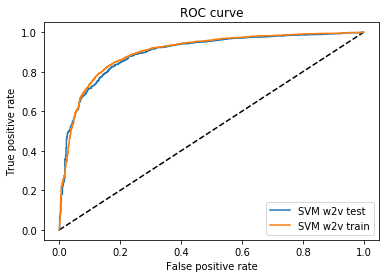

AUC SVM w2v Score TEST: 0.897231
AUC SVM w2v Score TRAIN: 0.902254


In [20]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_w2v_svm, tpr_w2v_svm, label='SVM w2v test')
plt.plot(fpr_w2v_tsvm, tpr_w2v_tsvm, label='SVM w2v train')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
print("AUC SVM w2v Score TEST: %f" % roc_auc_score(y_test_w2v, y_pred_w2v_svm))
print("AUC SVM w2v Score TRAIN: %f" % roc_auc_score(y_train_w2v, y_tpred_w2v_svm))

In [21]:
str_str='标准间太差房间还不如3星的而且设施非常陈旧.建议酒店把老的标准间从新改善'

In [22]:
X_data=[]
for word_str in (jieba.lcut(str_str)):
    try:
        vec_temp=get_sen_vec(word_str)
        X_data.append(vec_temp)
    except TypeError:
        continue
X_data=np.array(X_data)

In [29]:
X_data.mean(axis=0).shape

(128,)

In [34]:
X_train_w2v.shape

(7423, 128)

In [36]:
SVM_w2v.predict(X_data.mean(axis=0).reshape(1,-1))[0]

-1